In [578]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.tree import plot_tree
import seaborn as sns

In [530]:
data_origin = pd.read_csv('clinvar_conflicting.csv')
data_origin.head()

/opt/anaconda3/envs/6.86x/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (0,38,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [531]:
data_origin.shape

(65188, 46)

In [532]:
# data preprocessing
#
# Removing some columns from original data
removed_column = [
    'SSR', 'EXON', 'INTRON', 'DISTANCE',
    'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'
]
data_fixed= data_origin.drop(columns=removed_column, errors="ignore")
data_fixed.shape

(65188, 38)

In [533]:
#Creat bins for some important features
data_fixed[['CADD_PHRED', 'CADD_RAW']].agg(['min', 'max', 'mean'])

,CADD_PHRED,CADD_RAW
min,0.001000,-5.477391
max,99.000000,46.556261
mean,15.685616,2.554131


In [534]:
# Create bins for CADD_PHRED column
data_fixed['CADD_PHRED'] = pd.to_numeric(data_fixed['CADD_PHRED'], errors='coerce')

bins_phred = [0, 10, 20, 30, 60, 100]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

data_fixed['CADD_PHRED_bin'] = pd.cut(data_fixed['CADD_PHRED'], bins=bins_phred, labels=labels, include_lowest=True)

print(data_fixed[['CADD_PHRED', 'CADD_PHRED_bin']].head())

# Create bins for CADD_RAW column
data_fixed['CADD_RAW'] = pd.to_numeric(data_fixed['CADD_RAW'], errors='coerce')

bins_raw = [-6, 0, 5, 15, 30, 50]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

data_fixed['CADD_RAW_bin'] = pd.cut(data_fixed['CADD_RAW'], bins=bins_raw, labels=labels, include_lowest=True)

print(data_fixed[['CADD_RAW', 'CADD_RAW_bin']].head())


   CADD_PHRED CADD_PHRED_bin
0       1.053       Very Low
1      31.000           High
2      28.100       Moderate
3      22.500       Moderate
4      24.700       Moderate
   CADD_RAW CADD_RAW_bin
0 -0.208682     Very Low
1  6.517838     Moderate
2  6.061752     Moderate
3  3.114491          Low
4  4.766224          Low


In [535]:
# Checking how many number of unique values each column has
pd.DataFrame([[i, len(data_fixed[i].unique())] for i in data_fixed.columns], columns=['Column Name', 'Distinct Counts']).set_index('Column Name')

,Distinct Counts
Column Name,
CHROM,38
POS,63115
REF,866
ALT,458
AF_ESP,2842
AF_EXAC,6667
AF_TGP,2087
CLNDISDB,9234
CLNDISDBINCL,94


In [536]:
# Removing columns that contain unique values of more than 2500
distinct_count_col = pd.DataFrame([[i, len(data_fixed[i].unique())] for i in data_fixed.columns], columns=['Column Name', 'Distinct Counts']).set_index('Column Name')

drop_distinct_count_col = list(distinct_count_col[distinct_count_col['Distinct Counts'] > 2500].index)
data_fixed.drop(drop_distinct_count_col, axis=1, inplace=True)
data_fixed.shape

(65188, 28)

In [537]:
# Check number of nan in each row
nan_counts_per_row = data_fixed.isnull().sum(axis=1)
print(nan_counts_per_row)

0        5
1        4
2        4
3        8
4        7
        ..
65183    6
65184    3
65185    6
65186    8
65187    6
Length: 65188, dtype: int64


In [538]:
# Remove rows that contain nan value of 8 and more
drop_nan_row = data_fixed[data_fixed.isnull().sum(axis=1) >= 8]
data_fixed = data_fixed.drop(drop_nan_row.index).reset_index(drop=True)
data_fixed.isnull().sum(axis=1)

0        5
1        4
2        4
3        7
4        7
        ..
53192    6
53193    6
53194    3
53195    6
53196    6
Length: 53197, dtype: int64

In [539]:
unknown_data_column = [
    'SIFT', 'PolyPhen'
]
data_fixed[unknown_data_column] = data_fixed[unknown_data_column].fillna("Unknown")

In [540]:
# Checking number of nan in each column
data_fixed.isnull().sum().sort_values()

CHROM                 0
PolyPhen              0
SIFT                  0
STRAND                0
BIOTYPE               0
Feature               0
Feature_type          0
SYMBOL                0
Consequence           0
Allele                0
IMPACT                0
ORIGIN                0
REF                   0
ALT                   0
CLNVC                 0
AF_TGP                0
CLASS                 0
Amino_acids           9
Codons                9
CADD_PHRED_bin       52
CADD_RAW_bin         52
MC                  232
LoFtool            2658
BAM_EDIT          26812
BLOSUM62          27616
CLNDNINCL         53030
CLNSIGINCL        53030
CLNDISDBINCL      53030
dtype: int64

In [541]:
# Display missing data of each column as percentage
nan_number = data_fixed.isnull().sum()
nan_percentage = data_fixed.isnull().sum().apply(lambda x: x/data_fixed.shape[0]*100)
nan_data = pd.DataFrame({'Number of Nan value':  nan_number,'Percentage of Missing Data': nan_percentage})
nan_data['Percentage of Missing Data'].sort_values(ascending = False)

CLNDISDBINCL      99.686073
CLNDNINCL         99.686073
CLNSIGINCL        99.686073
BLOSUM62          51.912702
BAM_EDIT          50.401338
LoFtool            4.996522
MC                 0.436115
CADD_RAW_bin       0.097750
CADD_PHRED_bin     0.097750
Codons             0.016918
Amino_acids        0.016918
Feature            0.000000
PolyPhen           0.000000
SIFT               0.000000
STRAND             0.000000
BIOTYPE            0.000000
CHROM              0.000000
Feature_type       0.000000
REF                0.000000
IMPACT             0.000000
Consequence        0.000000
Allele             0.000000
CLASS              0.000000
ORIGIN             0.000000
CLNVC              0.000000
AF_TGP             0.000000
ALT                0.000000
SYMBOL             0.000000
Name: Percentage of Missing Data, dtype: float64

In [542]:
drop_nan_column = list(nan_data[nan_data['Percentage of Missing Data'] >= 50].index)
data_fixed.drop(drop_nan_column,axis = 1, inplace=True)
data_fixed.isnull().sum().sort_values()

CHROM                0
PolyPhen             0
SIFT                 0
STRAND               0
BIOTYPE              0
Feature              0
Feature_type         0
IMPACT               0
Consequence          0
SYMBOL               0
CLASS                0
ORIGIN               0
CLNVC                0
AF_TGP               0
ALT                  0
REF                  0
Allele               0
Amino_acids          9
Codons               9
CADD_PHRED_bin      52
CADD_RAW_bin        52
MC                 232
LoFtool           2658
dtype: int64

In [543]:
# Filling missing data 

data_fixed['CADD_PHRED_bin'] = data_fixed['CADD_PHRED_bin'].cat.add_categories('Missing').fillna('Missing')
data_fixed['CADD_RAW_bin'] = data_fixed['CADD_RAW_bin'].cat.add_categories('Missing').fillna('Missing')

frequent_data_column =[
    'Amino_acids', 'Codons', 'MC'
]
data_fixed[frequent_data_column] = data_fixed[frequent_data_column].fillna(data_fixed[frequent_data_column].mode().iloc[0])

In [544]:
data_fixed['LoFtool'] = data_fixed['LoFtool'].fillna(data_fixed['LoFtool'].mean())


In [545]:
data_fixed.isnull().sum()

CHROM             0
REF               0
ALT               0
AF_TGP            0
CLNVC             0
MC                0
ORIGIN            0
CLASS             0
Allele            0
Consequence       0
IMPACT            0
SYMBOL            0
Feature_type      0
Feature           0
BIOTYPE           0
Amino_acids       0
Codons            0
STRAND            0
SIFT              0
PolyPhen          0
LoFtool           0
CADD_PHRED_bin    0
CADD_RAW_bin      0
dtype: int64

In [546]:
y = data_fixed['CLASS']
data_fixed.drop(columns=['CLASS'], inplace=True)
y.dtypes

dtype('int64')

In [547]:
data_fixed['CADD_PHRED_bin'] = data_fixed['CADD_PHRED_bin'].astype(str)
data_fixed['CADD_RAW_bin'] = data_fixed['CADD_RAW_bin'].astype(str)
pd.DataFrame({'Unique Values': data_fixed.nunique(), 'Data Type': data_fixed.dtypes})

,Unique Values,Data Type
CHROM,37,object
REF,387,object
ALT,169,object
AF_TGP,1780,float64
CLNVC,6,object
MC,67,object
ORIGIN,29,int64
Allele,143,object
Consequence,26,object
IMPACT,4,object


In [548]:
feature_cols = [
    'CHROM', 'REF', 'ALT', 'AF_TGP', 'CLNVC', 
    'MC', 'OIRGIN', 'Allele', 'Consequence', 'IMPACT',
    'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 'Amino_acids',
    'Codons', 'STRAND', 'SIFT', 'PolyPhen', 'LoFtool', 'CADD_PHRED_bin', 'CADD_RAW_bin'
]

In [549]:
# Encoding 'object' data type into string
for col in data_fixed.select_dtypes(include='object').columns:
    data_fixed[col] = LabelEncoder().fit_transform(data_fixed[col].astype(str))
data_fixed.head()

,CHROM,REF,ALT,AF_TGP,CLNVC,MC,ORIGIN,Allele,Consequence,IMPACT,...,Feature,BIOTYPE,Amino_acids,Codons,STRAND,SIFT,PolyPhen,LoFtool,CADD_PHRED_bin,CADD_RAW_bin
0,0,194,40,0.1066,5,10,1,31,11,2,...,1613,0,151,1167,1.0,3,1,0.348777,5,5
1,0,194,0,0.0000,5,10,1,1,11,2,...,438,0,460,796,-1.0,2,1,0.348777,0,3
2,0,0,75,0.0000,5,14,35,64,11,2,...,803,0,287,572,-1.0,1,3,0.348777,3,3
3,0,194,126,0.0000,5,10,33,112,11,2,...,1796,0,218,358,1.0,0,0,0.348777,3,1
4,0,194,40,0.0000,5,10,33,31,11,2,...,1796,0,226,357,1.0,0,0,0.348777,3,1


In [550]:
# scaler = MinMaxScaler()
# scaled_array = scaler.fit_transform(data_fixed)

# # Convert back to DataFrame and preserve columns + index
# data_fixed = pd.DataFrame(scaled_array, columns=data_fixed.columns, index=data_fixed.index)
# data_fixed.head()

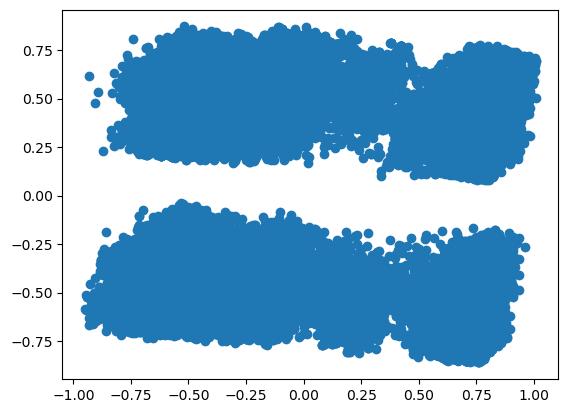

In [551]:
# Unsupervised learning 
# Apply PCA for visualization and dimensionality reduction
feature_cols = list(data_fixed.columns)
X = data_fixed[feature_cols]  
X_scaled = MinMaxScaler().fit_transform(X)
pca = PCA(n_components=22)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:,0], X_pca[:,1])


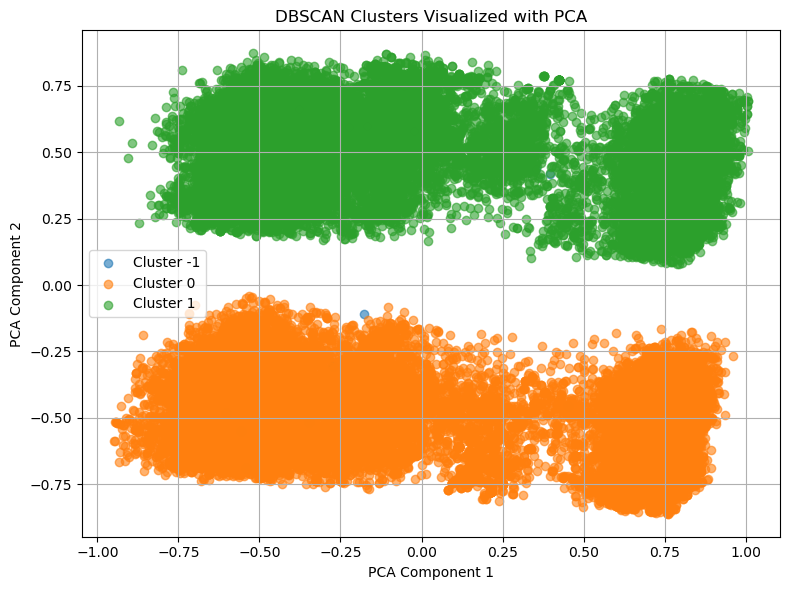

In [552]:
# Apply DBSCAN to see clusters
db = DBSCAN(eps=1.0, min_samples=5)
labels = db.fit_predict(X_scaled)
data_fixed['DBSCAN_cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = np.unique(data_fixed['DBSCAN_cluster'])

for label in unique_labels:
    mask = data_fixed['DBSCAN_cluster'] == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {label}', alpha=0.6)

plt.title('DBSCAN Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Num clusters: 1, Inertia: 92148.03044213838
Num clusters: 2, Inertia: 76565.51718929555
Num clusters: 3, Inertia: 67869.28218630931
Num clusters: 4, Inertia: 62735.754857891356
Num clusters: 5, Inertia: 59643.60995095496
Num clusters: 6, Inertia: 56899.98202540166
Num clusters: 7, Inertia: 55088.42349614676


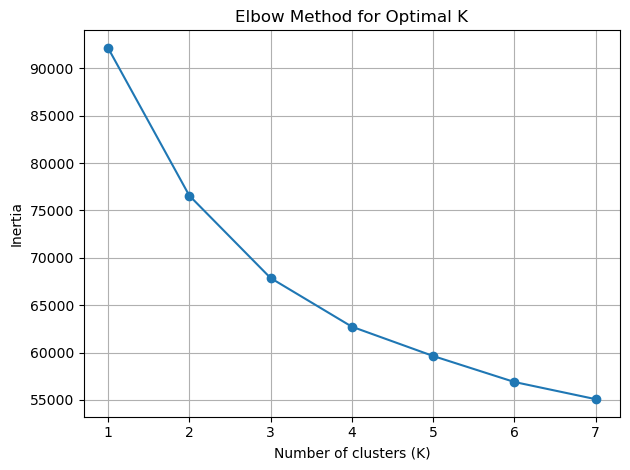

In [553]:
# Using Elbow method to select K
all_kmeans = [None] * 8
for i in range(1, 8):  # Start from 1 to avoid 0 clusters
    cur_kmeans = KMeans(n_clusters=i, n_init=10)
    cur_kmeans.fit(X_pca)
    print(f"Num clusters: {i}, Inertia: {cur_kmeans.inertia_}")
    all_kmeans[i] = cur_kmeans

# Plot the elbow curve
plt.plot(range(1, 8), [all_kmeans[i].inertia_ for i in range(1, 8)], marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


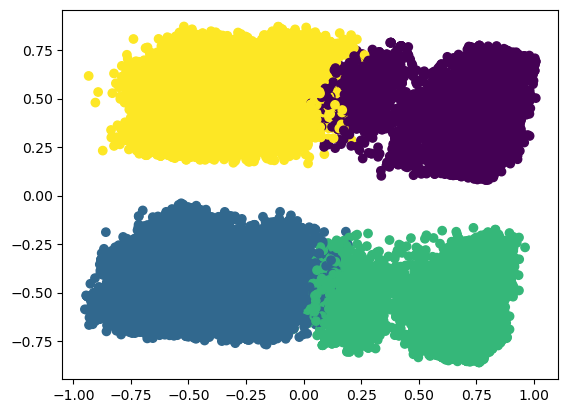

In [554]:
# Choose K to be 4 by looking at the result from Elbow method
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1],c=kmeans.labels_)

In [555]:
y.value_counts()

0    39916
1    13281
Name: CLASS, dtype: int64

In [556]:
# Supervised Learning
# Splitting data by preserving class proportions
X_train, X_test, y_train, y_test = train_test_split(
    data_fixed, y, 
    test_size=0.3,          
    random_state=42,        
    stratify=y              # preserves class proportions
)
print(X_train.shape)
print(X_test.shape)

(37237, 23)
(15960, 23)


In [557]:
# Decision Tree 
dt = DecisionTreeClassifier(random_state=42)

# Step 2: Fit on training data
dt.fit(X_train, y_train)

# Step 3: Predict on test data
y_pred_dt = dt.predict(X_test)

# Metrics
node_count     = dt.tree_.node_count
max_depth      = dt.tree_.max_depth
conf_matrix    = confusion_matrix(y_test, y_pred_dt)
class_report   = classification_report(y_test, y_pred_dt, output_dict=True)
acc            = accuracy_score(y_test, y_pred_dt)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Node Count', 'Max Depth', 'Accuracy'],
    'Value': [node_count, max_depth, acc]
})

print("Decision Tree Summary:")
print(summary_df)

conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['Actual 0', 'Actual 1'],
                              columns=['Predicted 0', 'Predicted 1'])

print("\nConfusion Matrix:")
print(conf_matrix_df)

class_report_df = pd.DataFrame(class_report).T

print("\nClassification Report:")
print(class_report_df)

Decision Tree Summary:
       Metric         Value
0  Node Count  17147.000000
1   Max Depth     39.000000
2    Accuracy      0.697619

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         9548         2427
Actual 1         2399         1586

Classification Report:
              precision    recall  f1-score       support
0              0.799196  0.797328  0.798261  11975.000000
1              0.395216  0.397992  0.396599   3985.000000
accuracy       0.697619  0.697619  0.697619      0.697619
macro avg      0.597206  0.597660  0.597430  15960.000000
weighted avg   0.698328  0.697619  0.697971  15960.000000


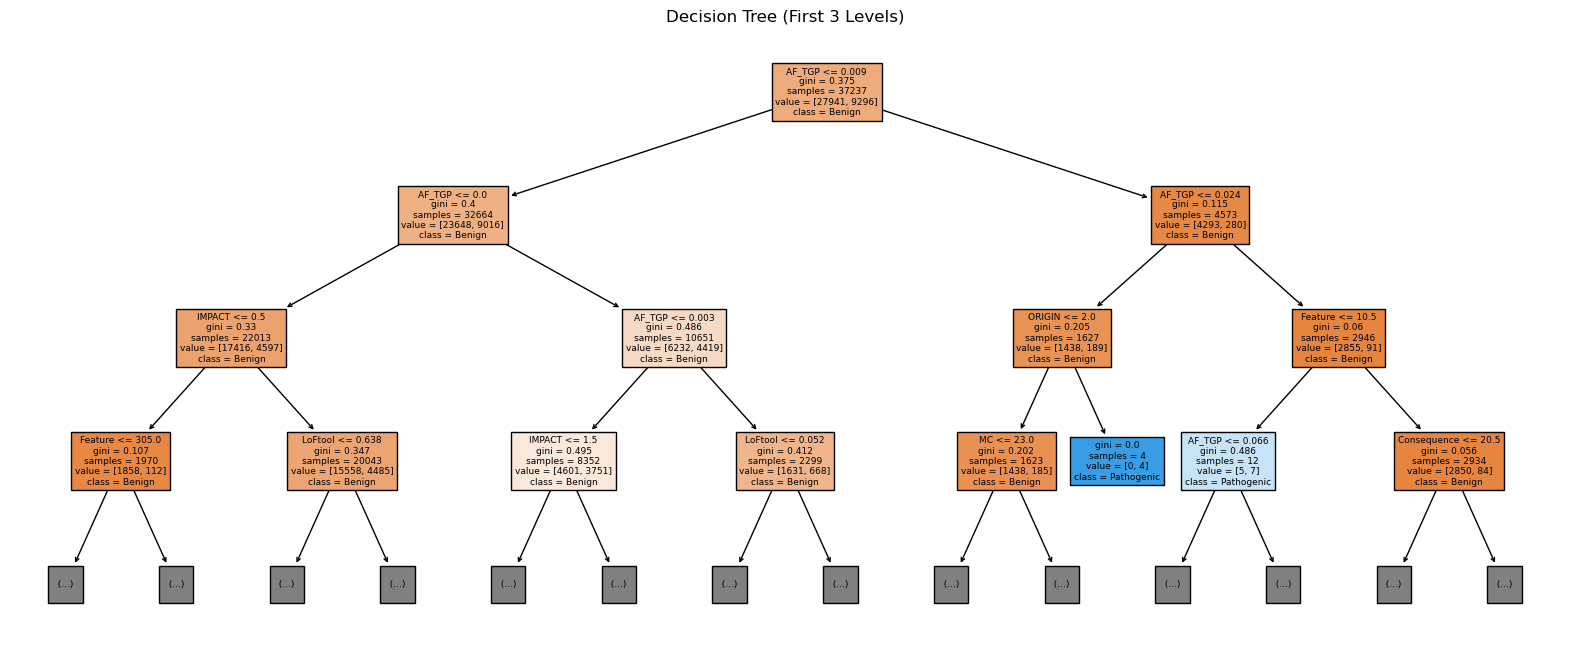

In [558]:
plt.figure(figsize=(20, 8))
plot_tree(dt, feature_names=X_train.columns, class_names=['Benign', 'Pathogenic'], filled=True, max_depth=3)
plt.title("Decision Tree (First 3 Levels)")
plt.show()

In [559]:
# Random Forest
# Initialize the model
rf = RandomForestClassifier(oob_score=True, warm_start=True, random_state=42, n_jobs=-1)
oob_list = []

# Iterate through different tree counts
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    
    # Collect out-of-bag error
    oob_error = 1 - rf.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

# Combine into a summary DataFrame
rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

/opt/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


,oob
n_trees,
15.0,0.272659
20.0,0.267503
30.0,0.262427
40.0,0.260332
50.0,0.258802
100.0,0.255418
150.0,0.252894
200.0,0.252330
300.0,0.251954


<Figure size 800x500 with 0 Axes>

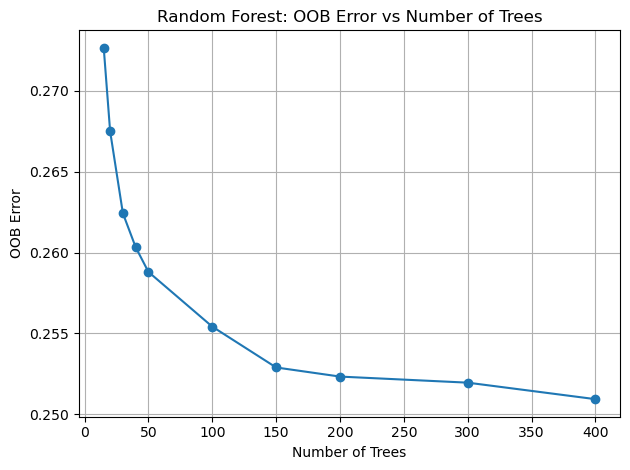

In [560]:
# Plot the OOB error curve
plt.figure(figsize=(8, 5))
rf_oob_df.plot(marker='o', legend=False)

plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("Random Forest: OOB Error vs Number of Trees")
plt.grid(True)
plt.tight_layout()
plt.show()

In [561]:
# Selecting number of trees in the range 300-400 by looking at OOB error graph
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced') 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

summary_rf = pd.DataFrame({
    'Metric': ['Accuracy'],
    'Value': [accuracy_score(y_test, y_pred_rf)]
})

# Confusion Matrix as a table
conf_matrix_rf = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rf),
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

# Classification Report as a DataFrame
class_report_rf = pd.DataFrame(
    classification_report(y_test, y_pred_rf, output_dict=True)
).T

print("Summary Accuracy:")
print(summary_rf)

print("\nConfusion Matrix:")
print(conf_matrix_rf)

print("\nClassification Report:")
print(class_report_rf.round(3))  # Rounded for readability

Summary Accuracy:
     Metric     Value
0  Accuracy  0.752318

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        11096          879
Actual 1         3074          911

Classification Report:
              precision  recall  f1-score    support
0                 0.783   0.927     0.849  11975.000
1                 0.509   0.229     0.315   3985.000
accuracy          0.752   0.752     0.752      0.752
macro avg         0.646   0.578     0.582  15960.000
weighted avg      0.715   0.752     0.716  15960.000


In [562]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance.head(10)

AF_TGP            0.153232
Codons            0.131162
Amino_acids       0.107183
Feature           0.095219
SYMBOL            0.094319
LoFtool           0.091324
CHROM             0.065968
CADD_PHRED_bin    0.037805
REF               0.032851
MC                0.025568
dtype: float64

In [566]:
lr = LogisticRegressionCV(penalty="l1",solver="liblinear",Cs=[.1,1,10],cv=3)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_df = pd.DataFrame({'Metric': ['Accuracy'], 'Value': [accuracy_score(y_test, y_pred_lr)]})

conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_lr),
                              index=['Actual 0', 'Actual 1'],
                              columns=['Predicted 0', 'Predicted 1'])

report_df = pd.DataFrame(
    classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
).T

# Display outputs
print("Accuracy Summary:")
print(accuracy_df)

print("\nConfusion Matrix:")
print(conf_matrix_df)

print("\nClassification Report:")
print(report_df.round(3))


Accuracy Summary:
     Metric     Value
0  Accuracy  0.750251

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        11972            3
Actual 1         3983            2

Classification Report:
              precision  recall  f1-score   support
0                 0.750   1.000     0.857  11975.00
1                 0.400   0.001     0.001   3985.00
accuracy          0.750   0.750     0.750      0.75
macro avg         0.575   0.500     0.429  15960.00
weighted avg      0.663   0.750     0.643  15960.00


In [567]:
coefs = pd.Series(lr.coef_[0], index=X_train.columns).sort_values(key=abs, ascending=False)
print("Top Influential Features:\n", coefs.head(10))

Top Influential Features:
 AF_TGP           -23.180841
DBSCAN_cluster    -1.216422
IMPACT             0.917541
STRAND            -0.699658
CLNVC             -0.059495
Consequence        0.023936
SIFT               0.022791
LoFtool           -0.018999
PolyPhen          -0.015496
MC                 0.011765
dtype: float64


In [568]:
# Define model names and predictions
models = {
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'Logistic Regression': y_pred_lr
}

# Store metrics
summary_rows = []
conf_matrices = {}
class_reports = {}

for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Accuracy summary
    summary_rows.append({'Model': name, 'Accuracy': acc})

    # Full tables
    conf_matrices[name] = pd.DataFrame(conf,
        index=['Actual 0', 'Actual 1'],
        columns=['Predicted 0', 'Predicted 1']
    )
    class_reports[name] = pd.DataFrame(report).T

summary_df = pd.DataFrame(summary_rows)

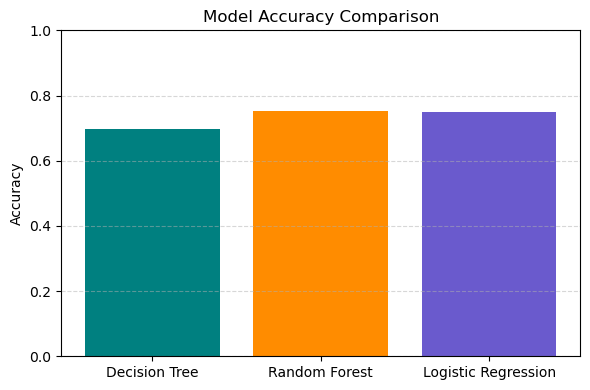

In [569]:
plt.figure(figsize=(6,4))
plt.bar(summary_df['Model'], summary_df['Accuracy'], color=['teal','darkorange','slateblue'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [575]:
# Accuracy table
print("Accuracy Summary:")
print(summary_df)


Accuracy Summary:
                 Model  Accuracy
0        Decision Tree  0.697619
1        Random Forest  0.752318
2  Logistic Regression  0.750251


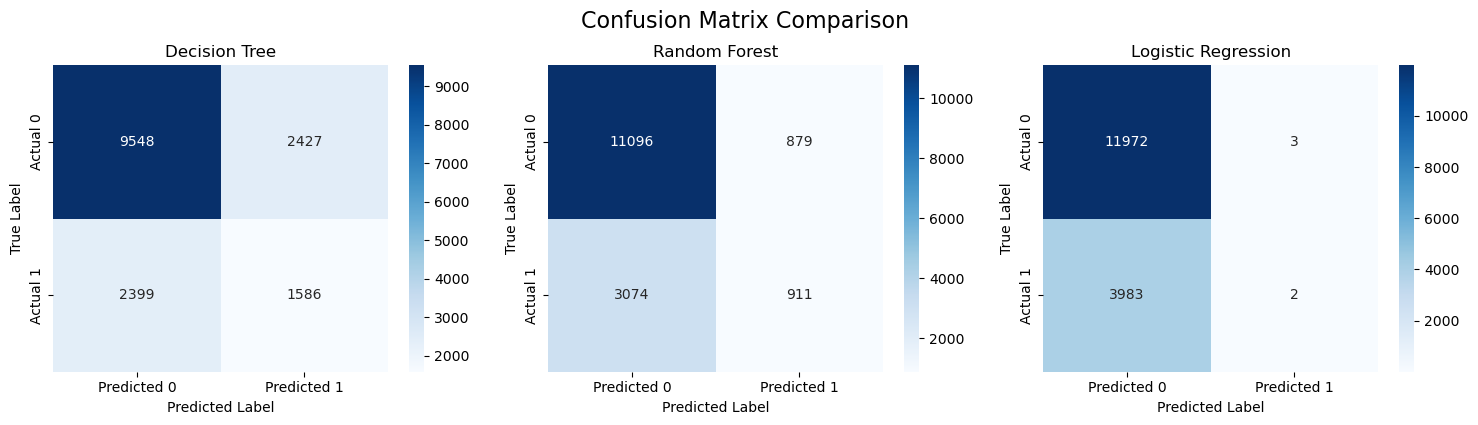

In [574]:
# Plot Confusion Matrices as Ground Truth
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, y_pred) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])

    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.suptitle('Confusion Matrix Comparison', fontsize=16, y=1.05)
plt.show()

                 Model  Precision  Recall  Accuracy  F1 Score    AUC
0        Decision Tree      0.597   0.598     0.698     0.597  0.598
1        Random Forest      0.646   0.578     0.752     0.582  0.578
2  Logistic Regression      0.575   0.500     0.750     0.429  0.500


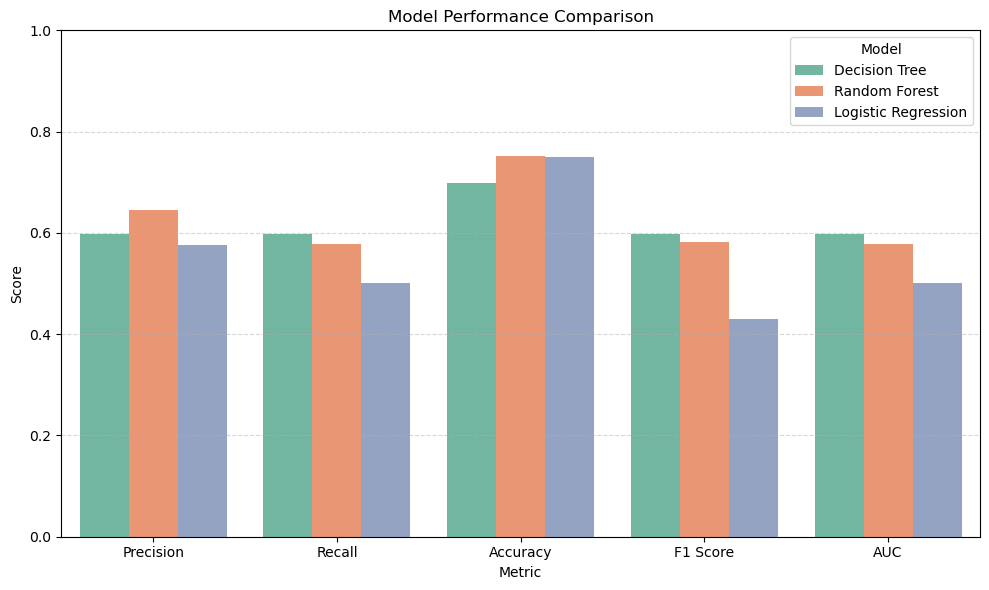

In [580]:
# Create list to hold rows
rows = []

for name, y_pred in models.items():
    row = {
        'Model': name,
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'AUC': roc_auc_score(y_test, y_pred)
    }
    rows.append(row)

# Convert to DataFrame
metrics_df = pd.DataFrame(rows)
print(metrics_df.round(3))  # Round for clean display
# Melt the DataFrame for easier plotting
plot_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model', palette='Set2')

plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Model')
plt.tight_layout()
plt.show()